# Regression Assumptions Demonstration Notebook
This notebook illustrates regression assumptions one by one with examples of violations and transformations/fixes.

In [ ]:
# !pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

np.random.seed(42)

## Function: Scatter plot with regression line and R^2

In [2]:
def fit_ols(x, y):
    """Fits OLS regression and returns model and predicted values."""
    X_const = sm.add_constant(x)
    model = sm.OLS(y, X_const).fit()
    y_pred = model.predict(X_const)
    return model, y_pred

def plot_scatter_with_line(x, y, y_pred, r2, title="Scatter with Regression", xlabel="X", ylabel="Y"):
    """Plots scatter plot and regression line with R^2."""
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, label="Data")
    plt.plot(x, y_pred, color='red', label=f"Regression line\n$R^2={r2:.2f}$")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def scatter_with_regression(x, y, title="Scatter with Regression", xlabel="X", ylabel="Y"):
    model, y_pred = fit_ols(x, y)
    r2 = r2_score(y, y_pred)
    plot_scatter_with_line(x, y, y_pred, r2, title, xlabel, ylabel)
    return model
    
def scatter_with_regression_zoom(x, y, title="Scatter with Regression", 
                                 xlabel="X", ylabel="Y", zoom=(0,0)):
    """
    Fit OLS on full data, but optionally zoom in by removing extremes from plotting.
    zoom = (n_x, n_y) removes n_x extreme points from x and n_y from y (top or bottom)
    """
    # If x is a single-column DataFrame, convert to Series
    if isinstance(x, pd.DataFrame) and x.shape[1] == 1:
        x = x.iloc[:,0]
        
    # Fit full model
    model, y_pred = fit_ols(x, y)
    
    # Determine indices to keep
    idx_x = np.arange(len(x))
    idx_y = np.arange(len(y))
    
    if zoom[0] > 0:
        # Remove n_x most extreme x values (top or bottom)
        sorted_x_idx = np.argsort(x)
        idx_x = sorted_x_idx[zoom[0]:-zoom[0]] if zoom[0]*2 < len(x) else sorted_x_idx
    if zoom[1] > 0:
        # Remove n_y most extreme y values (top or bottom)
        sorted_y_idx = np.argsort(y)
        idx_y = sorted_y_idx[zoom[1]:-zoom[1]] if zoom[1]*2 < len(y) else sorted_y_idx
    
    # Intersection of indices to keep
    keep_idx = np.intersect1d(idx_x, idx_y)
    
    # Filter for plotting only
    x_plot = x.iloc[keep_idx] if isinstance(x, pd.Series) else x[keep_idx]
    y_plot = y.iloc[keep_idx] if isinstance(y, pd.Series) else y[keep_idx]
    y_pred_plot = y_pred[keep_idx]
    
    # Plot
    r2 = r2_score(y, y_pred)
    plot_scatter_with_line(x_plot, y_plot, y_pred_plot, r2, title=title, xlabel=xlabel, ylabel=ylabel)
    
    return model

## Function: Scatter two predictors side by side with regression lines from full model

In [3]:
def scatter_two_predictors_side_by_side_with_predictions(X, y, predictor1, predictor2):
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    
    for i, col in enumerate([predictor1, predictor2]):
        x = X[col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        y_pred = model.predict(X_const)
        r2 = r2_score(y, y_pred)
        
        # Plot scatter and regression line
        sorted_idx = x.argsort()
        x_sorted = x.iloc[sorted_idx]
        y_pred_sorted = y_pred.iloc[sorted_idx]
        axes[i].scatter(x, y, label="Data", alpha=0.6)
        axes[i].plot(x_sorted, y_pred_sorted, color='red', label=f"Regression line\n$R^2={r2:.2f}$")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Y")
        axes[i].set_title(f"{col} vs Y (full model regression)")
        axes[i].legend()
    
    # Plot predicted vs observed Y
    y_pred_full = sm.OLS(y, sm.add_constant(X)).fit().predict(sm.add_constant(X))
    axes[2].scatter(y, y_pred_full, color='green', alpha=0.6, label="Predicted vs Observed")
    axes[2].plot([y.min(), y.max()], [y.min(), y.max()], color='black', linestyle='--', label='Perfect prediction')
    axes[2].set_xlabel("Observed Y")
    axes[2].set_ylabel("Predicted Y")
    axes[2].set_title("Predicted vs Observed Y")
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()


## Step 1: No Violation Example

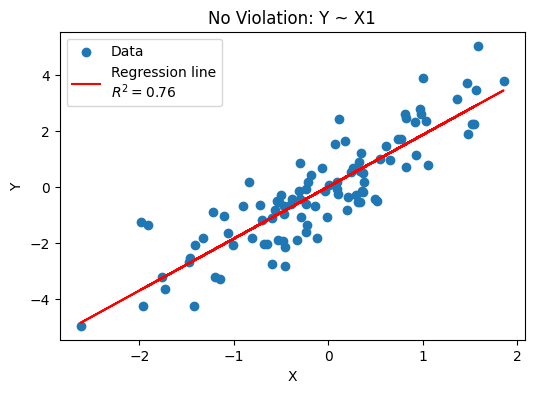

In [4]:
n = 100
X = pd.DataFrame({'X1': np.random.normal(0,1,n)})
Y = 2*X['X1'] + np.random.normal(0,1,n)
scatter_with_regression(X, Y, title="No Violation: Y ~ X1")

## Step 2: Non-linearity (Y ~ X^2)

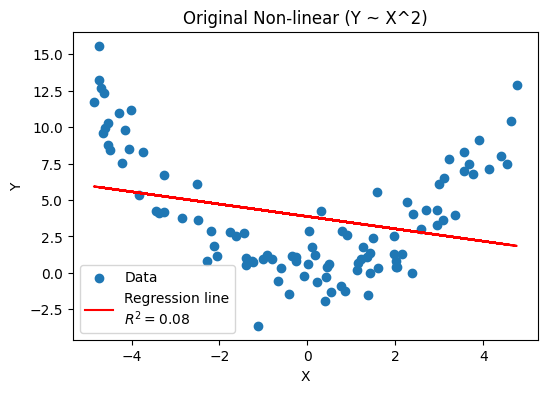

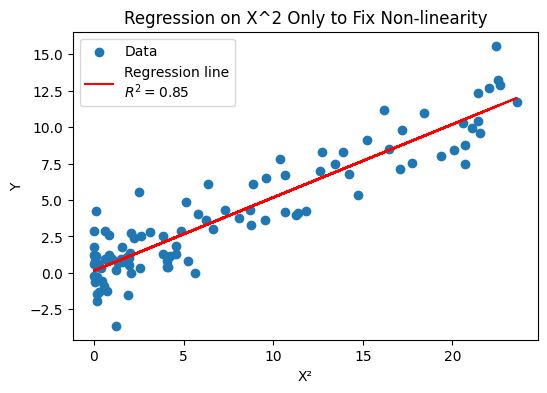

In [5]:
X = pd.DataFrame({'X': np.random.uniform(-5,5,n)})
Y = 0.5*X['X']**2 + np.random.normal(0,2,n)

# Original non-linear
scatter_with_regression(X, Y, title="Original Non-linear (Y ~ X^2)")

# Fix: regress only on X^2
X_squared = pd.DataFrame({'X2': X['X']**2})
scatter_with_regression(X_squared, Y, title="Regression on X^2 Only to Fix Non-linearity",
                        xlabel="X²")


## Step 3: Independence Violation (Autocorrelation)

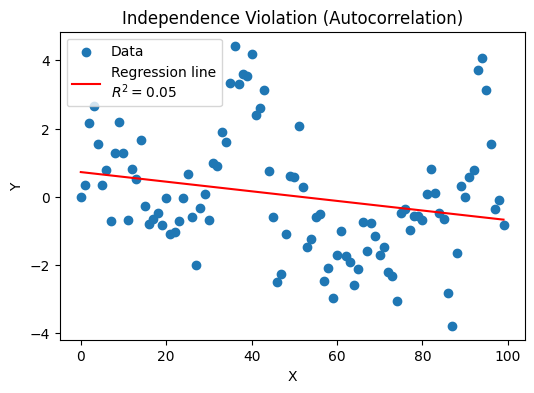

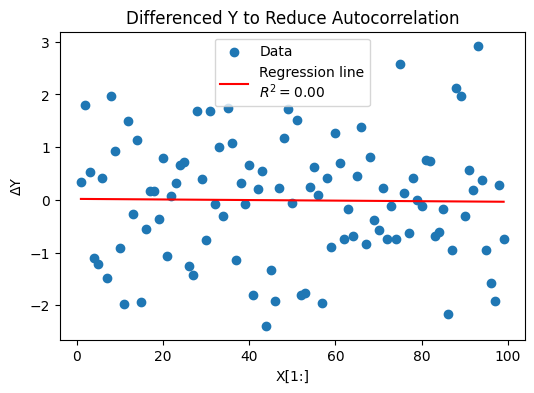

In [6]:
Y = np.zeros(n)
for i in range(1,n):
    Y[i] = 0.8*Y[i-1] + np.random.normal(0,1)
X = pd.DataFrame({'X': np.arange(n)})

scatter_with_regression(X, Y, title="Independence Violation (Autocorrelation)")

# Fix: difference transform
Y_diff = np.diff(Y)
X_diff = X['X'][1:]
scatter_with_regression(X_diff, Y_diff, title="Differenced Y to Reduce Autocorrelation",
                        xlabel="X[1:]", ylabel="ΔY")


## Step 4: Heteroscedasticity

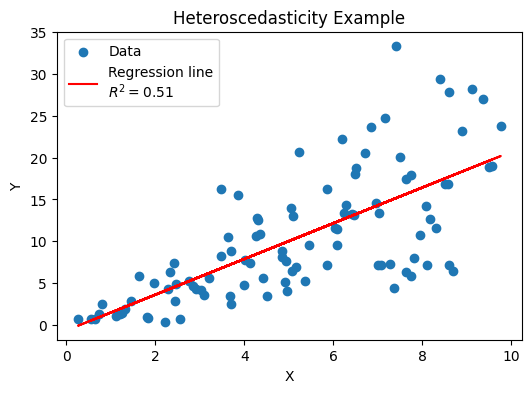

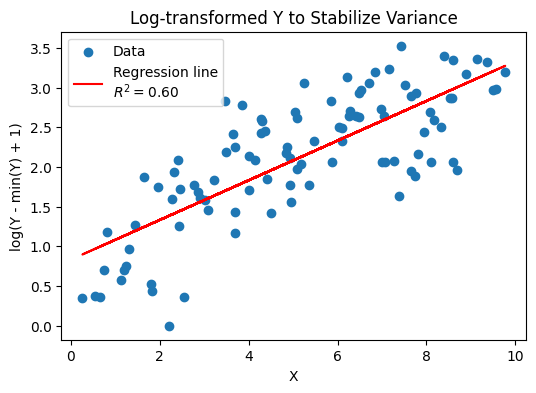

In [7]:
np.random.seed(300)
X = pd.DataFrame({'X': np.random.uniform(0,10,n)})
Y = 2*X['X'] + np.random.normal(0, X['X'], n)  # increasing variance
scatter_with_regression(X, Y, title="Heteroscedasticity Example")

# Fix: log-transform Y
Y_log = np.log(Y - Y.min() + 1)
scatter_with_regression(X, Y_log, title="Log-transformed Y to Stabilize Variance",
                        ylabel="log(Y - min(Y) + 1)")

### Step 5: Non-normal residuals

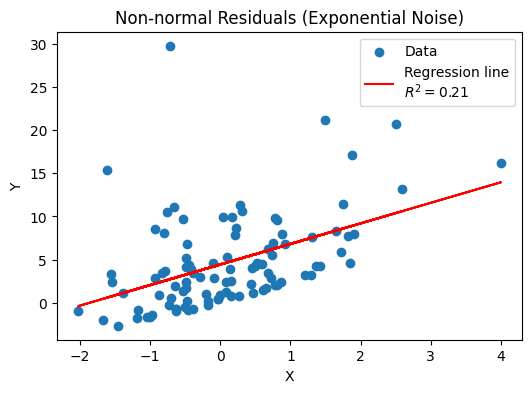

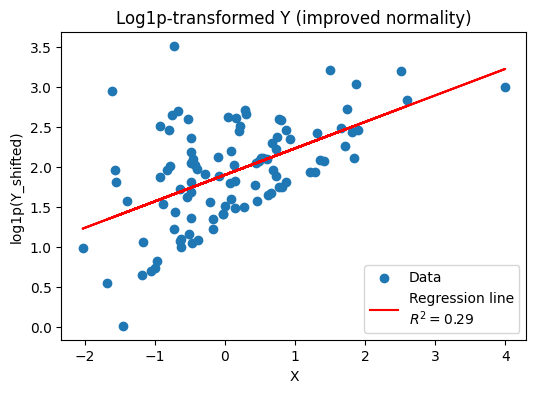

In [8]:
# Generate data
X = pd.DataFrame({'X': np.random.normal(0,1,n)})
Y = 2*X['X'] + np.random.exponential(scale=5, size=n)

# Show non-normal residuals
scatter_with_regression(X, Y, title="Non-normal Residuals (Exponential Noise)")

# Fix: shift so all Y > 0 before log-transform
min_Y = Y.min()
shift = 0.01 if min_Y >= 0 else -min_Y + 0.01
Y_shifted = Y + shift
Y_log = np.log1p(Y_shifted)

scatter_with_regression(X, Y_log, title="Log1p-transformed Y (improved normality)",
                        ylabel="log1p(Y_shifted)")


## Step 6: Multicollinearity

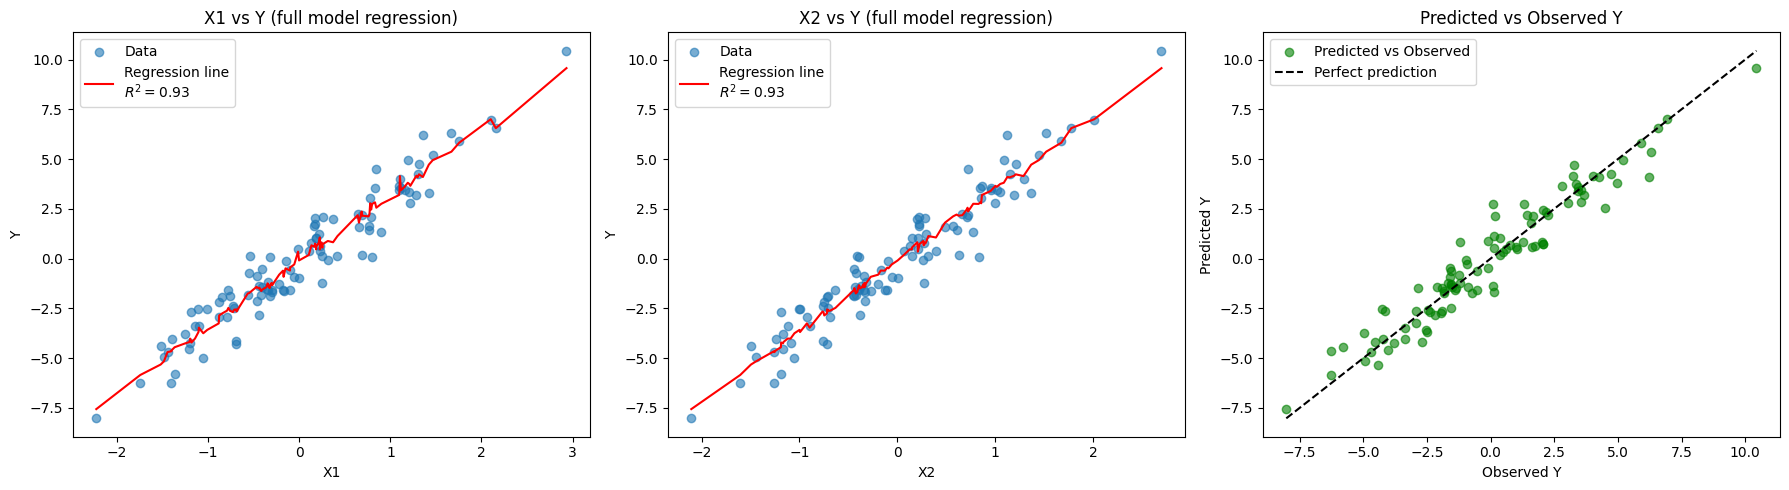

In [9]:
X = pd.DataFrame({'X1': np.random.normal(0,1,n)})
X['X2'] = X['X1']*0.9 + np.random.normal(0,0.1,n)  # highly correlated
Y = 2*X['X1'] + 1.5*X['X2'] + np.random.normal(0,1,n)

# scatter_two_predictors_side_by_side(X, Y, 'X1','X2')
scatter_two_predictors_side_by_side_with_predictions(X, Y, 'X1','X2')

# ⬆  
**Triple Plot Explanation (Multicollinearity Example)**

**Y vs X1**  
- Red line: regression using all predictors (X1 & X2)  
- You may see that the slope of the red line doesn’t match the raw correlation of X1 and Y, because the model has to “share” X1’s effect with X2.

**Y vs X2**  
- Same idea: slope might be surprising because X2 is correlated with X1.  
- If X2 were included alone, the slope would be biased high, because it absorbs some of X1’s effect.

**Predicted Y vs Observed Y**  
- Even though coefficients are unstable, the predicted Y (green points) is close to actual Y → model predicts well.  

**Takeaway:**  
This illustrates a key multicollinearity point: good prediction doesn’t mean good coefficient estimates.


## Step 7: Outliers / Influential Points

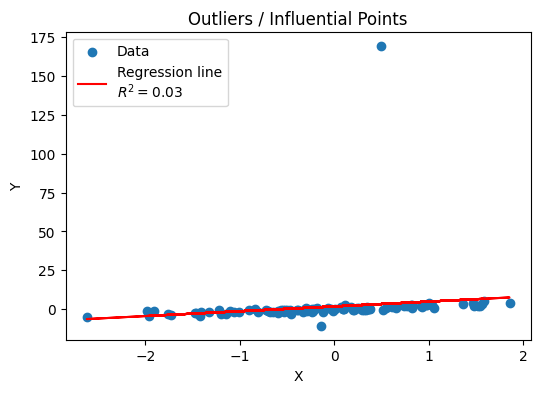

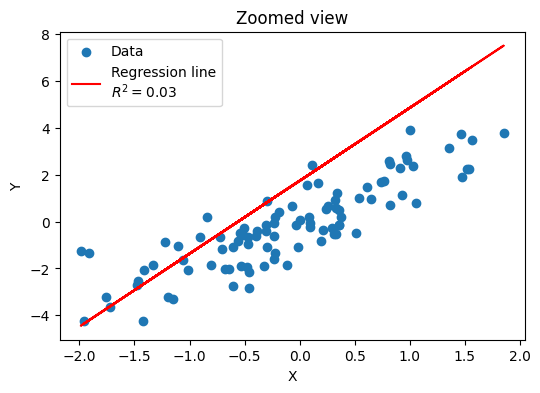

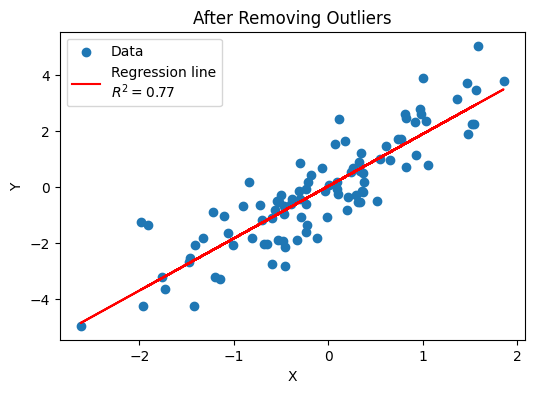

In [10]:
np.random.seed(42)
X = pd.DataFrame({'X': np.random.normal(0,1,n)})
Y = 2*X['X'] + np.random.normal(0,1,n)
# Add outliers
Y[0] += 170
Y[1] -= 10
scatter_with_regression(X, Y, title="Outliers / Influential Points")

# Plot first graph WITHOUT the high/low outliers
# Y_out = Y.copy()
# scatter_with_regression(X.iloc[1:], Y_out.iloc[1:], title="Outliers / Influential Points (excluded in plot)")

scatter_with_regression_zoom(X, Y, title="Zoomed view", zoom=(0,2))

# Fix: remove outliers
X_clean = X.drop([0,1])
Y_clean = Y.drop([0,1])
scatter_with_regression(X_clean, Y_clean, title="After Removing Outliers")

## Step 8: Omitted Variable Bias

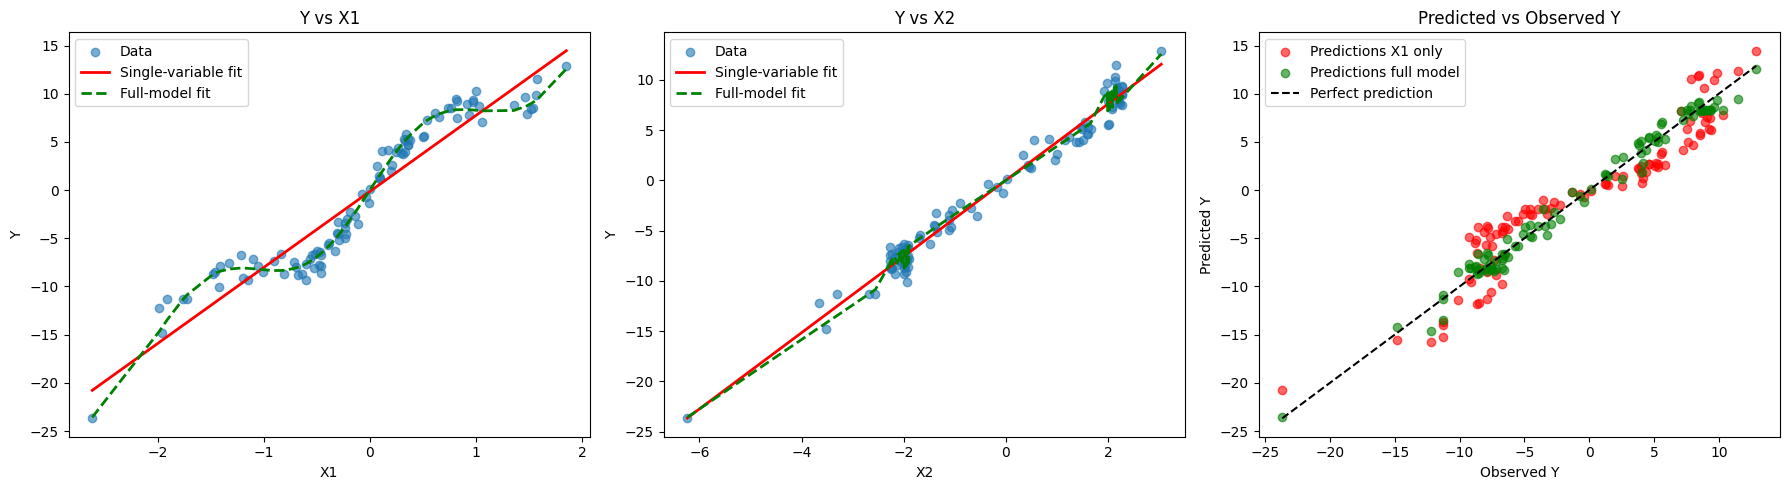

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     858.1
Date:                Fri, 22 Aug 2025   Prob (F-statistic):           2.85e-50
Time:                        09:42:53   Log-Likelihood:                -229.71
No. Observations:                 100   AIC:                             463.4
Df Residuals:                      98   BIC:                             468.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1326      0.245     -0.542      0.5

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(42)
n = 100

# Generate predictors
X1 = np.random.normal(0, 1, n)
X2 = 2*X1 + np.sin(3*X1)  # correlated + patterned noise

# True outcome
Y = 2*X1 + 3*X2 + np.random.normal(0, 1, n)

X = pd.DataFrame({'X1': X1, 'X2': X2})

# Full model
X_const = sm.add_constant(X)
model_full = sm.OLS(Y, X_const).fit()
y_pred_full = model_full.predict(X_const)

# Single-variable regressions
model_X1_only = sm.OLS(Y, sm.add_constant(X['X1'])).fit()
y_pred_X1_only = model_X1_only.predict(sm.add_constant(X['X1']))

model_X2_only = sm.OLS(Y, sm.add_constant(X['X2'])).fit()
y_pred_X2_only = model_X2_only.predict(sm.add_constant(X['X2']))

# Plot side by side plus predictions
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# --- Y vs X1 ---
sorted_idx = X['X1'].argsort()
axes[0].scatter(X['X1'], Y, alpha=0.6, label='Data')
axes[0].plot(X['X1'].iloc[sorted_idx], y_pred_X1_only.iloc[sorted_idx], color='red', linewidth=2, label='Single-variable fit')
axes[0].plot(X['X1'].iloc[sorted_idx], y_pred_full.iloc[sorted_idx], color='green', linewidth=2, linestyle='--', label='Full-model fit')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('Y')
axes[0].set_title('Y vs X1')
axes[0].legend()

# --- Y vs X2 ---
sorted_idx = X['X2'].argsort()
axes[1].scatter(X['X2'], Y, alpha=0.6, label='Data')
axes[1].plot(X['X2'].iloc[sorted_idx], y_pred_X2_only.iloc[sorted_idx], color='red', linewidth=2, label='Single-variable fit')
axes[1].plot(X['X2'].iloc[sorted_idx], y_pred_full.iloc[sorted_idx], color='green', linewidth=2, linestyle='--', label='Full-model fit')
axes[1].set_xlabel('X2')
axes[1].set_ylabel('Y')
axes[1].set_title('Y vs X2')
axes[1].legend()

# --- Y_pred vs Y
axes[2].scatter(Y, y_pred_X1_only, alpha=0.6, color='red', label='Predictions X1 only')
axes[2].scatter(Y, y_pred_full, alpha=0.6, color='green', label='Predictions full model')
axes[2].plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='black', linestyle='--', label='Perfect prediction')
axes[2].set_xlabel('Observed Y')
axes[2].set_ylabel('Predicted Y')
axes[2].set_title('Predicted vs Observed Y')
axes[2].legend()

plt.tight_layout()
plt.show()


print(model_X1_only.summary(),'\n')
print(model_X2_only.summary(),'\n')
print(model_full.summary(),'\n')